# Solar-System15-Mixed-Precision

<ul id="top">
<li><a href="#Load-packages"> 
             Load Packages</a></li>
    
<li><a href="#Computer-properties"> 
             Computer properties</a></li> 

<li><a href="#Initial-value-problem:-Solar-System15">
              Initial value problem: Solar-System15</a></li>

<li><a href="#Ode-problem">
             Ode problem</a></li>
 
<li><a href="#Error-in-energy">
             Error in energy</a></li> 

<li><a href="#Work-Precision-diagrams">
             Work-Precision diagrams</a></li> 

</ul>  

## Load packages

In [1]:
using OrdinaryDiffEq,DiffEqDevTools,BenchmarkTools
using IRKGaussLegendre
using Plots,LinearAlgebra
using Dates
using RecursiveArrayTools
using JLD2, FileIO

In [2]:
setprecision(BigFloat, 108);

In [3]:
#plotly()

<a href="#top">Back to the top</a>

## Computer properties

In [3]:
#export JULIA_NUM_THREADS=2
Threads.nthreads()

1

In [5]:
#;cat /proc/cpuinfo # on Linux machines

In [4]:
using Hwloc
Hwloc.num_physical_cores()

2

<a href="#top">Back to the top</a>

## Initial value problem: Solar-System15

In [21]:
include("../examples/Nbody.jl")
include("../examples/InitialNBody15.jl")

setprecision(BigFloat, 108)
u0128, Gm128 =InitialNBody15(BigFloat)

q0128=u0128[2,:,:]
v0128=u0128[1,:,:]

dt=5
t0=0.0
t1=20*dt    #20, 1000.
mysaveat=1  #10

u064, Gm64 =InitialNBody15(Float64)
lpp=Gm64;

tspan128=(BigFloat(t0),BigFloat(t1))
prob128 = ODEProblem(NbodyODE!,u0128,tspan128,Gm128,;lpp=lpp);

<a href="#top">Back to the top</a>

## Ode problem

### Test solution

In [8]:
#sol =solve(prob128,Vern9(),saveat=mysaveat,abstol=1e-24,reltol=1e-24,maxiters=100000);
#@save "./Data/solarsystem15small_test_solF128.jld2" sol
@load "./Data/solarsystem15small_test_solF128.jld2" sol
test_sol = TestSolution(sol);

### IRKGL16 (Fixed-Step)

In [23]:
(sol1,iters1,steps1) =solve(prob128,IRKGL16(),dt=dt,saveat=mysaveat,adaptive=false,myoutputs=true,
                             mixed_precision=false);
sol1.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  1982
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          6
Number of rejected steps:                          0

In [10]:
mean(iters1)

22.61904761904762

In [11]:
(sol2,iters2,steps2) = solve(prob128,IRKGL16(),dt=dt,saveat=mysaveat,adaptive=false,myoutputs=true,
                             mixed_precision=true, low_prec_type=Float64);
sol2.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  1005
Number of function 2 evaluations:                  8196
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          20
Number of rejected steps:                          0

In [12]:
mean(iters2)

7.523809523809524

<a href="#top">Back to the top</a>

## DynamicalProblem

In [13]:
probdyn128 = DynamicalODEProblem(NbodyODEq!,NbodyODEv!,q0128,v0128,tspan128,Gm128,;lpp=lpp);

### IRKGL16 (Fixed-Step)

In [16]:
(sol11,iters11,steps11) =solve(probdyn128,IRKGL163(),dt=dt,saveat=mysaveat,adaptive=true,myoutputs=true,
              mixed_precision=false);
sol11.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  2296
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          6
Number of rejected steps:                          0

<a href="#top">Back to the top</a>

## Error in energy

In [19]:
setprecision(BigFloat, 256)
u0256, Gm256 =InitialNBody15(BigFloat)
E0=NbodyEnergy(u0256,Gm256)

ΔE = map(x->NbodyEnergy(BigFloat.(x),Gm256), sol.u)./E0.-1
ΔE1 = map(x->NbodyEnergy(BigFloat.(x),Gm256), sol1.u)./E0.-1
ΔE2 = map(x->NbodyEnergy(BigFloat.(x),Gm256), sol2.u)./E0.-1
ΔE11 = map(x->NbodyEnergy2(BigFloat.(x),Gm256), sol11.u)./E0.-1
#ΔE12 = map(x->NbodyEnergy2(BigFloat.(x),Gm128), sol12.u)./E0.-1

(Float32(maximum(abs.(ΔE))),Float32(maximum(abs.(ΔE1))),Float32(maximum(abs.(ΔE2))),Float32(maximum(abs.(ΔE11))))

(1.2841041f-27, 2.6668344f-12, 2.5345949f-21, 2.6668344f-12)

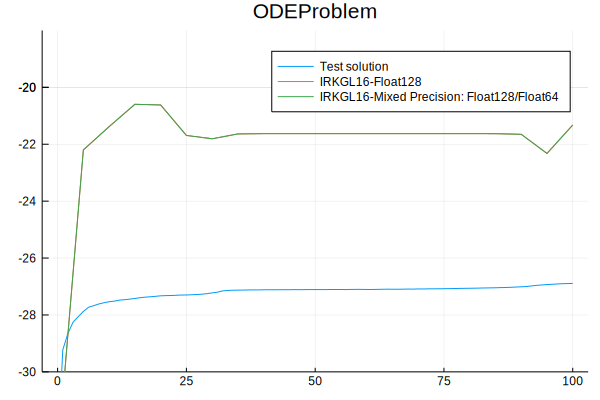

In [16]:
ylimit1=-30
ylimit2=-18
plot(sol.t,log10.(abs.(ΔE)), label="Test solution", title="ODEProblem",
    ylims=(ylimit1,ylimit2),)
plot!(sol1.t,log10.(abs.(ΔE1)), label="IRKGL16-Float128",
     ylims=(ylimit1,ylimit2),)
plot!(sol2.t,log10.(abs.(ΔE2)), label="IRKGL16-Mixed Precision: Float128/Float64",
     ylims=(ylimit1,ylimit2),)

In [17]:
#ylimit1=-30
#ylimit2=-18
#plot(sol.t,log10.(abs.(ΔE)), label="Test solution", title="DynamicalProblem",
#    ylims=(ylimit1,ylimit2),)
#plot!(sol1.t,log10.(abs.(ΔE11)), label="IRKGL16-Float128",
#     ylims=(ylimit1,ylimit2),)
#plot!(sol2.t,log10.(abs.(ΔE12)), label="IRKGL16-Mixed Precision: Float128/Float64",
#     ylims=(ylimit1,ylimit2),)

<a href="#top">Back to the top</a>

## Work-Precision diagrams

In [ ]:
now()

In [18]:
setprecision(BigFloat, 108)

108

In [19]:
Threads.nthreads()

1

In [20]:
abstols = 1.0 ./ 10.0 .^ (12:26)
reltols = 1.0 ./ 10.0 .^ (12:26)
dts=16*0.866.^(0:length(reltols)-1)

11-element Array{Float64,1}:
 16.0               
 13.856             
 11.999296          
 10.391390335999999 
  8.998944030976    
  7.793085530825215 
  6.748812069694637 
  5.8444712523555555
  5.061312104539911 
  4.383096282531563 
  3.7957613806723334

### OdeProblem

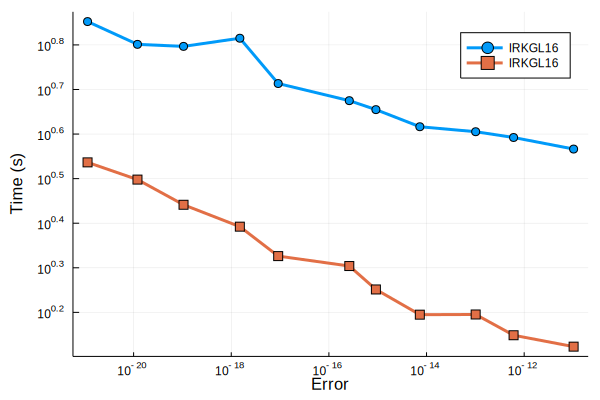

In [21]:
setups = [ Dict(:alg=>Vern9())
           Dict(:alg=>IRKGL16(),:adaptive=>true, :mixed_precision=>false)
           Dict(:alg=>IRKGL16(),:adaptive=>true, :mixed_precision=>false,:low_prec_type=>Float64))
           Dict(:alg=>IRKGL16(),:adaptive=>false,:dts=>dts,:mixed_precision=>false) 
           Dict(:alg=>IRKGL16(),:adaptive=>false,:dts=>dts,:mixed_precision=>true,:low_prec_type=>Float64)
]
wp1 = WorkPrecisionSet(prob128,abstols,reltols,setups;appxsol=test_sol,save_everystep=false,numruns=1,maxiters=1000000)
plot(wp1)

In [ ]:
now()

### Dynamical Problem

In [22]:
ux=sol.u[end]
solx=ArrayPartition(ux[2,:,:],ux[1,:,:])
test_solx = TestSolution(tspan128,[solx]);

In [23]:
setups = [ Dict(:alg=>Vern9())
           Dict(:alg=>IRKGL163(),:adaptive=>false,:dts=>dts,:mixed_precision=>true,:low_prec_type=>Float64)
]
wp2 = WorkPrecisionSet(probdyn128,abstols,reltols,setups;appxsol=test_solx,save_everystep=false,numruns=1,maxiters=1000000)
plot(wp2)

### SeconOrderProblem

In [ ]:
using RecursiveArrayTools
prob2nd128 = SecondOrderODEProblem(NbodyODE2nd!,v0128,q0128,tspan128,Gm128);

In [ ]:
solx=ArrayPartition(ux[2,:,:],ux[1,:,:])
test_solx = TestSolution(tspan128,[solx]);

In [24]:
setups = [
          Dict(:alg=>DPRKN12())   
]
wp3 = WorkPrecisionSet(prob2nd128,abstols,reltols,setups;appxsol=test_solx,save_everystep=false,numruns=1,maxiters=100000)
plot(wp3)



<a href="#top">Back to the top</a>